In [1]:
import matplotlib.pyplot as plt
from src.plot_utils import *
from src.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath

In [ ]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (3,1.5)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

# # FUNCTIONS
def recreate_config(experiment):
    with initialize(version_base=None, config_path="../configs"):
        cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=walle-smpuglie", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
        HydraConfig.instance().set_config(cfg)

    for k in cfg.paths.keys():
        if (k != 'user'):
            cfg.paths[k] = Path(cfg.paths[k])
            cfg.paths[k].mkdir(parents=True, exist_ok=True)

    return cfg

In [3]:
experiment = "DNg100_1000_replicates"
config = recreate_config(experiment)
name = config.experiment.name
RPath = f"/data/users/smpuglie/Pugliese_2025/{name}/debug/run_id=Testing/ckpt/{name}_Rs.npz"
Rs = sparse.load_npz(RPath).todense()


In [4]:
dataset = 0
Rs = Rs[dataset]
Rs.shape

(2, 4603, 2000)

/home/smpuglie/Pugliese_2025/src/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


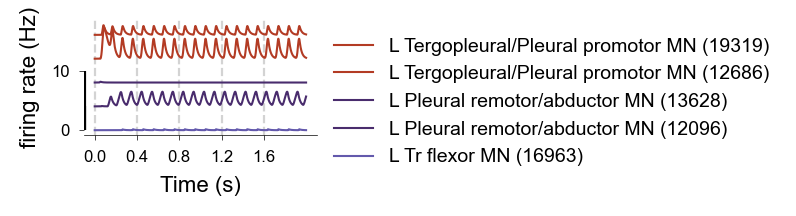

Rhythmicity score:  0.759
Frequency:  10.204 Hz


In [5]:
simToPlot = 0
spacer = 4
scalebar = 10
width = 1.5

###
R = Rs[simToPlot]

wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20250722_DNtoMN_unsorted_withModules.csv")
allMNs = sort_motor_modules(wTable.loc[wTable["class"] == "motor neuron"])

plt.figure()
ax = plot_R_traces_stacked_by_module(R,allMNs,activeOnly=True,space=spacer)
add_tAxis(ax,config.sim.T,5)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,scalebar,"k")
plt.yticks([0,scalebar])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
fig = plt.gcf()
fig.set_figheight(0.15*len(get_active_data(R[allMNs.index],allMNs)))
fig.set_figwidth(width)

plt.show()

# activeMNs = get_active_data(R[allMNs.index],allMNs)
activeMnsMask = (np.sum(R,1)>1) & (jnp.isin(jnp.arange(R.shape[0]), allMNs.index.to_numpy()))
score, freq = compute_oscillation_score(R[...,250:],activeMnsMask)# ,returnFrequency=True)
print(f"Rhythmicity score: {float(score): .3f}")
print(f"Frequency: {float(freq) / config.sim.dt: .3f} Hz")